
 ****** Running generation 0 ****** 

Population's average fitness: -98.41290 stdev: 29.88896
Best fitness: -39.40608 - size: (4, 96) - species 1 - id 50
Average adjusted fitness: 0.461
Mean genetic distance 1.406, standard deviation 0.251
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50    -39.4    0.461     0
Total extinctions: 0
Generation time: 32.069 sec
Node: (0, <function tanh_activation at 0x79bad0340700>, <function sum_aggregation at 0x79bad0341480>, 0.007679913530630693, 1.0, [(-1, -0.422127978537118), (-2, -0.05376110967615104), (-3, 0.7229493736750726), (-4, 0.1455687565463688), (-5, 0.5927345460840825), (-6, -1.495096476792777), (-7, -0.797558215998877), (-8, -0.14197005224929532), (-9, 0.9280208187999507), (-10, -0.23788202727587385), (-11, 1.541295029731625), (-12, -0.19977760927998195), (-13, -1.4127245684215979), (-14, -1.0610745546698084), (-15, -1.5917018942285999), (-16, 0.3

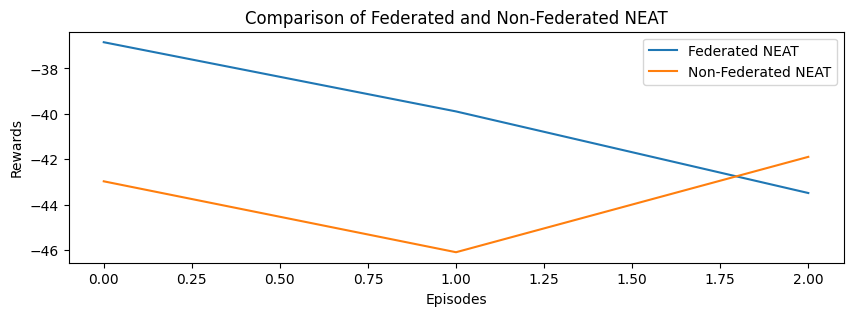

In [54]:
# !apt-get update
# !apt-get install python3-dev python3-pip python3-setuptools gcc libffi-dev libssl-dev

# !pip install tensorflow tensorflow-federated gym numpy matplotlib swig box2d-py gym[box2d] neat --no-cache-dir
# !pip install --upgrade tensorflow_probability tensorflow_model_optimization tensorflow-estimator==2.3.0
# !pip install --upgrade tensorflow tensorflow-federated

import warnings
import neat
import gym
import pickle
import os
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt
import logging
import concurrent.futures

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Constants
CONFIG_PATH = './neat_config.txt'
BEST_GENOME_PATH = './best_genome.pkl'
DEMO_FILE = './demonstrations.pkl'
MAX_GEN = 1
NUM_CLIENTS = 3
NUM_ROUNDS = 10
MAX_EPISODES = 500
EPISODES_PER_EVALUATION = 2

# Define a custom Keras layer for NEAT network
class NEATLayer(tf.keras.layers.Layer):
    def __init__(self, neat_network, **kwargs):
        super(NEATLayer, self).__init__(**kwargs, dynamic=True)  # Pass dynamic=True
        self.neat_network = neat_network

    def call(self, inputs):
        def neat_activate(x):
            return np.array(self.neat_network.activate(x), dtype=np.float32)

        outputs = tf.map_fn(lambda x: neat_activate(x), inputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 4)  # Assuming the NEAT network outputs 4 values

# Federated Learning Testing and Benchmarking Class
class FederatedLearningTest:
    def __init__(self, clients, model_fn, trainer, state, config, demonstrations):
        self.clients = clients
        self.model_fn = model_fn
        self.trainer = trainer
        self.state = state
        self.config = config
        self.demonstrations = demonstrations

    def run_federated_training(self, rounds=NUM_ROUNDS):
        metrics_list = []
        for round_num in range(rounds):
            client_data = [collect_client_data(client[0], client[1]) for client in self.clients]
            result = self.trainer.next(self.state, client_data)
            self.state = result.state
            metrics_list.append(result.metrics)
            logger.info(f'Round {round_num} metrics: {result.metrics}')
        return metrics_list

    def evaluate_model(self, env, network, episodes=MAX_GEN):
        total_reward = 0
        for _ in range(episodes):
            state = env.reset()
            done = False
            while not done:
                action = np.clip(network.activate(state), -1, 1)
                state, reward, done, _ = env.step(action)
                total_reward += reward
        return total_reward / episodes

    def plot_metrics(self, metrics_list):
        rounds = range(len(metrics_list))
        mse = [metrics['mean_squared_error'].numpy() for metrics in metrics_list]
        plt.figure(figsize=(10, 3))
        plt.plot(rounds, mse, label='Mean Squared Error')
        plt.xlabel('Rounds')
        plt.ylabel('Mean Squared Error')
        plt.title('Federated Learning Training Metrics')
        plt.legend()
        plt.show()

    def plot_rewards(self, rewards):
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(rewards)), rewards, label='Rewards')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Model Rewards Over Episodes')
        plt.legend()
        plt.show()

    def benchmark(self, baseline_reward):
        neat_network = neat.nn.FeedForwardNetwork.create(pickle.load(open(BEST_GENOME_PATH, 'rb')), self.config)
        client_rewards = [self.evaluate_model(client[0], neat_network) for client in self.clients]
        avg_reward = np.mean(client_rewards)

        logger.info(f'Average reward after federated learning: {avg_reward}')
        logger.info(f'Baseline reward: {baseline_reward}')

        plt.figure(figsize=(10, 3))
        plt.bar(['Baseline', 'Federated Learning'], [baseline_reward, avg_reward])
        plt.ylabel('Average Reward')
        plt.title('Benchmarking')
        plt.show()

# Helper function to create environments and networks for each client
def create_environment_and_network(client_id, variation, config):
    env = gym.make('BipedalWalker-v3')
    env._max_episode_steps = MAX_EPISODES  # Reduce max episode steps to speed up
    env.env.gravity = variation * client_id
    genome = load_genome(BEST_GENOME_PATH)
    network = neat.nn.FeedForwardNetwork.create(genome, config)
    return env, network

def create_neat_config(path):
    config_content = """
    [NEAT]
    fitness_criterion = max
    fitness_threshold = 300
    pop_size = 10
    reset_on_extinction = False
    [DefaultGenome]
    num_hidden = 0
    num_inputs = 24
    num_outputs = 4
    initial_connection = full
    activation_default = tanh
    activation_mutate_rate = 0.1
    activation_options = tanh relu sigmoid
    aggregation_default = sum
    aggregation_mutate_rate = 0.0
    aggregation_options = sum
    bias_init_mean = 0.0
    bias_init_stdev = 1.0
    bias_max_value = 30.0
    bias_min_value = -30.0
    bias_mutate_power = 0.5
    bias_mutate_rate = 0.7
    bias_replace_rate = 0.1
    response_init_mean = 1.0
    response_init_stdev = 0.0
    response_max_value = 30.0
    response_min_value = -30.0
    response_mutate_power = 0.0
    response_mutate_rate = 0.0
    response_replace_rate = 0.0
    compatibility_disjoint_coefficient = 1.0
    compatibility_weight_coefficient = 0.5
    conn_add_prob = 0.5
    conn_delete_prob = 0.5
    enabled_default = True
    enabled_mutate_rate = 0.01
    feed_forward = True
    node_add_prob = 0.2
    node_delete_prob = 0.2
    weight_init_mean = 0.0
    weight_init_stdev = 1.0
    weight_max_value = 30
    weight_min_value = -30
    weight_mutate_power = 0.5
    weight_mutate_rate = 0.8
    weight_replace_rate = 0.1
    [DefaultSpeciesSet]
    compatibility_threshold = 3.0
    [DefaultStagnation]
    species_fitness_func = max
    max_stagnation = 20
    species_elitism = 2
    [DefaultReproduction]
    elitism = 2
    survival_threshold = 0.2
    [SteadyState]
    replacement_rate = 0.2
    """
    if not os.path.exists(path):
        with open(path, 'w') as config_file:
            config_file.write(config_content.strip())
        logger.info(f"Created new NEAT configuration file at {path}")
    else:
        logger.info(f"NEAT configuration file already exists at {path}")

# Check and create configuration file if needed
create_neat_config(CONFIG_PATH)

try:
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, CONFIG_PATH)
except Exception as e:
    logger.error(f"Failed to load NEAT configuration: {e}")
    exit(1)

# Evaluate genomes function with reinforcement learning from demonstrations (RLfD), Parallel processing of genomes evaluation
def evaluate_genome(genome_id, genome, config):
    env = gym.make('BipedalWalker-v3')
    env._max_episode_steps = MAX_EPISODES  # Reduce max episode steps to speed up
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    fitness = 0
    try:
        for _ in range(EPISODES_PER_EVALUATION):
            state = env.reset()
            done = False
            while not done:
                action = np.clip(net.activate(state), -1, 1)
                state, reward, done, _ = env.step(action)
                fitness += reward
    except gym.error.Error as e:
        logger.error(f"Gym environment error during genome {genome_id} evaluation: {e}")
    except Exception as e:
        logger.error(f"Unexpected error during genome {genome_id} evaluation: {e}")
    finally:
        env.close()
    return fitness / EPISODES_PER_EVALUATION, genome

def evaluate_genomes(genomes, config):
    with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = [executor.submit(evaluate_genome, genome_id, genome, config) for genome_id, genome in genomes]
        for future in concurrent.futures.as_completed(futures):
            try:
                fitness, genome = future.result()
                genome.fitness = fitness
            except Exception as e:
                logger.error(f"Error evaluating genome in parallel: {e}")

# TensorFlow Federated model function using the NEAT genome
def model_fn():
    genome = load_genome(BEST_GENOME_PATH)
    neat_network = neat.nn.FeedForwardNetwork.create(genome, config)
    model = create_tf_model_from_neat(neat_network)

    return tff.learning.models.from_keras_model(
        keras_model=model,
        input_spec=(
            tf.TensorSpec(shape=[None, 24], dtype=tf.float32),
            tf.TensorSpec(shape=[None, 4], dtype=tf.float32)
        ),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()])

# Collect client data for federated learning using Gym environments
def collect_client_data(environment, net, episodes=MAX_GEN):
    data = []
    try:
        for _ in range(episodes):
            state = environment.reset()
            done = False
            while not done:
                action = np.clip(net.activate(state), -1, 1)
                next_state, reward, done, _ = environment.step(action)
                data.append((state, action, reward, next_state, done))
                state = next_state
        states, actions, rewards, next_states, dones = zip(*data)
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((states, actions))
        return dataset.batch(32)
    except Exception as e:
        logger.error(f"Error collecting client data: {e}")
        return None

# Create demonstrations for reinforcement learning, saved as pickle
if not os.path.exists(DEMO_FILE):
    env_demo = gym.make('BipedalWalker-v3')
    demos = []
    for _ in range(5):  # Reduce number of demonstrations to speed up
        state = env_demo.reset()
        done = False
        while not done:
            action = env_demo.action_space.sample()  # Random actions as placeholders
            next_state, _, done, _ = env_demo.step(action)
            demos.append((state, action))
            state = next_state
    with open(DEMO_FILE, 'wb') as f:
        pickle.dump(demos, f)
demonstrations = pickle.load(open(DEMO_FILE, 'rb'))

# Ensure the genome loading function is correct
def load_genome(filepath):
    try:
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        logger.error(f"Error: File '{filepath}' not found. Exiting.")
        raise SystemExit

# Evaluate genomes with RLfD using demonstrations
def evaluate_with_demos(genomes, config, env, demonstrations):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        fitness = 0
        for _ in range(EPISODES_PER_EVALUATION):  # Reduce the number of episodes for quicker evaluation
            state = env.reset()
            done = False
            while not done:
                action = np.clip(net.activate(state), -1, 1)
                state, reward, done, _ = env.step(action)
                fitness += reward
        genome.fitness = fitness / EPISODES_PER_EVALUATION  # Adjust to match the number of episodes

# Training function
def federated_train(num_clients=NUM_CLIENTS, num_rounds=NUM_ROUNDS):
    clients = [create_environment_and_network(i, 1.0 + 0.1 * i, config) for i in range(num_clients)]
    train_data = [collect_client_data(client[0], client[1]) for client in clients]
    model = model_fn()
    trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))
    state = trainer.initialize()
    for round_num in range(num_rounds):
        result = trainer.next(state, train_data)
        state = result.state
        metrics = result.metrics
        logger.info(f'Round {round_num + 1}: {metrics["client_work"]["train"]["mean_squared_error"]}')

    return state, metrics

# NEAT training function for non-federated learning
def train_neat_non_federated(config, episodes=MAX_GEN):
    env = gym.make('BipedalWalker-v3')
    env._max_episode_steps = MAX_EPISODES  # Reduce max episode steps to speed up
    population = neat.Population(config)
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)
    winner = population.run(lambda genomes, config: evaluate_genomes(genomes, config), episodes)
    return winner, stats

# Plotting function for comparing federated and non-federated results
def plot_comparison(federated_rewards, non_federated_rewards):
    plt.figure(figsize=(10, 3))
    episodes = range(len(federated_rewards))
    plt.plot(episodes, federated_rewards, label='Federated NEAT')
    plt.plot(episodes, non_federated_rewards, label='Non-Federated NEAT')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Comparison of Federated and Non-Federated NEAT')
    plt.legend()
    plt.show()

def extract_neat_weights(neat_network, num_inputs, num_outputs):
    hidden_weights = []
    output_weights = []
    hidden_biases = []
    output_biases = []

    # Assuming outputs are the last 'num_outputs' nodes
    output_node_start_index = len(neat_network.node_evals) - num_outputs

    for node in neat_network.node_evals:
        print(f"Node: {node}")  # Debug print to understand node structure
        node_index, activation, aggregation, bias, response, inputs = node[:6]

        if node_index >= output_node_start_index:
            for input_conn in inputs:
                output_weights.append(input_conn[1])  # Append the weight
            output_biases.append(bias)
        else:
            for input_conn in inputs:
                hidden_weights.append(input_conn[1])  # Append the weight
            hidden_biases.append(bias)

    return hidden_weights, output_weights, hidden_biases, output_biases

def create_tf_model_from_neat(neat_network):
    num_inputs = 24  # as per your NEAT config
    num_outputs = 4  # as per your NEAT config

    hidden_weights, output_weights, hidden_biases, output_biases = extract_neat_weights(neat_network, num_inputs, num_outputs)

    inputs = tf.keras.Input(shape=(24,))
    x = inputs

    if hidden_weights:
        x = tf.keras.layers.Dense(units=len(hidden_weights), activation='relu', use_bias=True,
                                  kernel_initializer=tf.keras.initializers.Constant(hidden_weights),
                                  bias_initializer=tf.keras.initializers.Constant(hidden_biases))(x)

    x = tf.keras.layers.Dense(units=4, activation='tanh', use_bias=True,
                              kernel_initializer=tf.keras.initializers.Constant(output_weights),
                              bias_initializer=tf.keras.initializers.Constant(output_biases))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Main Execution
if __name__ == "__main__":
    # Create NEAT population and evaluate genomes
    population = neat.Population(config)
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)

    # Run NEAT to get the best genome if not already saved
    if not os.path.exists(BEST_GENOME_PATH):
        winner = population.run(lambda genomes, config: evaluate_genomes(genomes, config))
        with open(BEST_GENOME_PATH, 'wb') as f:
            pickle.dump(winner, f)

    # Load the best genome and continue training with RLfD
    winner = pickle.load(open(BEST_GENOME_PATH, 'rb'))
    winner = population.run(lambda genomes, config: evaluate_with_demos(genomes, config, create_environment_and_network(1, 1.0, config)[0], demonstrations), MAX_GEN)
    with open(BEST_GENOME_PATH, 'wb') as f:
        pickle.dump(winner, f)

    # Federated training
    clients = [create_environment_and_network(i, 1.0 + 0.1 * i, config) for i in range(NUM_CLIENTS)]
    trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))
    state = trainer.initialize()

    test = FederatedLearningTest(clients, model_fn, trainer, state, config, demonstrations)
    state, final_metrics = federated_train(NUM_CLIENTS, NUM_ROUNDS)

    # Non-federated training
    winner, stats = train_neat_non_federated(config, MAX_GEN)
    with open('winner_genome.pkl', 'wb') as f:
        pickle.dump(winner, f)

    # Benchmark and compare results
    neat_network = neat.nn.FeedForwardNetwork.create(pickle.load(open(BEST_GENOME_PATH, 'rb')), config)
    federated_rewards = [test.evaluate_model(client[0], neat_network) for client in clients]
    non_federated_rewards = [test.evaluate_model(client[0], neat_network, MAX_GEN) for client in clients]

    plot_comparison(federated_rewards, non_federated_rewards)